In [131]:
import cartopy
import cartopy.crs as ccrs
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString
import math

In [2]:
hubs = ['ALBE', 'ALDE', 'AT', 'BE', 'CZ', 'DE_LU', 'FR', 'HR', 'HU', 'NL', 'PL', 'RO', 'SI', 'SK']

In [207]:
df_grid = pd.read_excel('./grid_connected.xlsx', index_col=0)
df_substations = pd.read_excel('./substations.xlsx', index_col=0)
df_powerplants = pd.read_excel('./power_plants.xlsx', index_col=0)

gdf_substations = gpd.GeoDataFrame(
    df_substations, geometry=gpd.points_from_xy(df_substations.lon, df_substations.lat))

for index, row in gdf_substations.iterrows():
    aggregated_capacity = df_powerplants[df_powerplants.node == index]['capacity'].agg('sum')
    gdf_substations.loc[index, 'aggregated_capacity'] = aggregated_capacity

In [208]:
for index, row in df_grid.iterrows():
    df_grid.loc[index, 'start_lon'] = df_substations.loc[row.substation_1, 'lon']
    df_grid.loc[index, 'start_lat'] = df_substations.loc[row.substation_1, 'lat']
    
    df_grid.loc[index, 'end_lon'] = df_substations.loc[row.substation_2, 'lon']
    df_grid.loc[index, 'end_lat'] = df_substations.loc[row.substation_2, 'lat']
    
gdf_grid = gpd.GeoDataFrame(
    df_grid, geometry=gpd.points_from_xy(df_grid.start_lon, df_grid.start_lat), crs=4326)

for index, row in gdf_grid.iterrows():
    gdf_grid.loc[index, 'geometry'] = LineString([(row.start_lon, row.start_lat), (row.end_lon, row.end_lat)])
    
gdf_grid = gdf_grid.drop(columns=['start_lon', 'end_lon', 'start_lat', 'end_lat'])
gdf_substations = gdf_substations.drop(columns=['lon', 'lat'])

In [209]:
gdf_network = pd.concat([gdf_substations, gdf_grid])
#gdf_network = gdf_network[~gdf_network.geometry.is_empty]

C:\Users\balazs.riskutia\FBMC\fbmc_geo_env\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


In [201]:
# (RTE) remove: 594, 423, 568, 1127, 1011, 327, 585, 14, 1209, 363, 215, 
# 1012, 661, 764, 838, 1272, 254, 1055, 755, 589, 116, 967, 863, 1023, 11, 1068, 282
comp_nodes = [282]
comp = gdf_network[gdf_network.substation_1.isin(comp_nodes) & gdf_network.substation_2.isin(comp_nodes)]

In [210]:
gdf_network.explore()

In [8]:
edgelist = []
for index, row in df_grid.iterrows():
    edgelist.append((row.substation_1, row.substation_2))

Grid = nx.Graph(edgelist)

positions = {}
node_attributes = {}
edge_attributes = {}

for index, row in df_substations.iterrows():
    positions[index] = (row.lon, row.lat)
    node_attributes[index] = {
        "zone": row.zone
    }
    
for index, row in df_substations.iterrows():
    positions[index] = (row.lon, row.lat)
    node_attributes[index] = {
        "zone": row.zone
    }
    
nx.set_node_attributes(Grid, node_attributes)

C:\Users\balazs.riskutia\FBMC\fbmc_geo_env\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


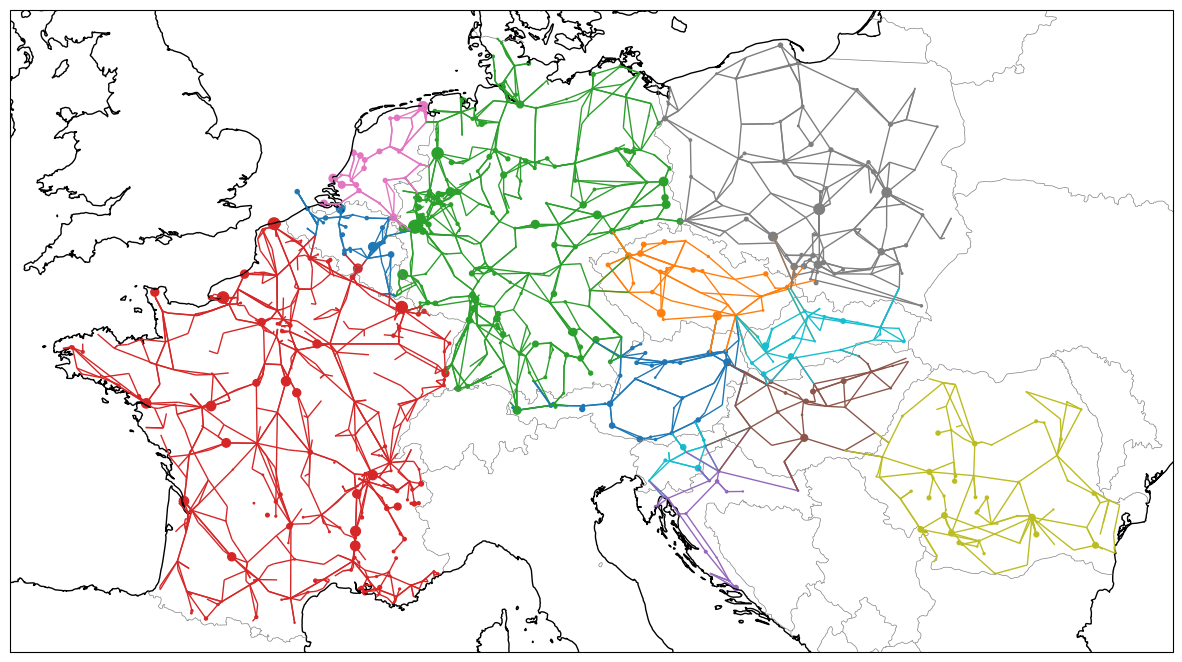

In [211]:
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree())

gdf_network.plot(
    ax=ax,
    column='zone',
    markersize=gdf_network.aggregated_capacity/0.8e2,
    linewidth=1
)

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color='grey', linewidth=0.5)